In [ ]:
import numpy as np

def sdr_to_mt6(strike, dip, rake):
    """
    Convert (strike,dip,rake) → [Mrr, Mtt, Mpp, Mrt, Mrp, Mtp]
    in ObsPy’s spherical order for beach(), fixing the r-axis sign.
    """
    # 1) SD → fault normal & slip in NED (x=N, y=E, z=DOWN)
    φ = np.radians(strike)
    δ = np.radians(dip)
    λ = np.radians(rake)

    n = np.array([
        -np.sin(δ)*np.sin(φ),   # N
         np.sin(δ)*np.cos(φ),   # E
        -np.cos(δ)              # DOWN
    ])
    s = np.array([
         np.cos(λ)*np.cos(φ) + np.sin(λ)*np.cos(δ)*np.sin(φ),
         np.cos(λ)*np.sin(φ) - np.sin(λ)*np.cos(δ)*np.cos(φ),
        -np.sin(λ)*np.sin(δ)
    ])

    # 2) Full tensor in NED
    M_ned = np.outer(n, s) + np.outer(s, n)

    # 3) Extract in spherical (r=up, θ=north, φ=east) order, with proper signs:
    Mrr =  M_ned[2, 2]        # up–up (radial–radial)
    Mtt =  M_ned[0, 0]        # north–north (theta–theta)
    Mpp =  M_ned[1, 1]        # east–east  (phi–phi)
    Mrt = -M_ned[2, 0]        # up–north  (radial–theta)
    Mrp = -M_ned[2, 1]        # up–east   (radial–phi)
    Mtp =  M_ned[0, 1]        # north–east(theta–phi)

    return [Mrr, Mtt, Mpp, Mrt, Mrp, Mtp]


In [ ]:
# If ObsPy is not installed, uncomment the following:
# !pip install obspy

%matplotlib inline
import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach

# Focal mechanism parameters
strike = 315  # degrees
dip    = 60   # degrees
rake   = 90   # degrees

# Create figure and axis
fig, ax = plt.subplots(figsize=(5, 5))

# Plot beachball at (0, 0)
ball = beach((strike,dip,rake),
             xy=(0, 0),
             width=2,
             facecolor='lightgray',
             edgecolor='black')
ax.add_collection(ball)

# Set limits, aspect, and labels
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Beachball: Strike={strike}°, Dip={dip}°, Rake={rake}°')

plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach

def strike_dip_rake_to_mt(strike, dip, rake, M0=1.0):
    """
    Convert strike, dip, rake to moment tensor components for ObsPy beach function.
    
    Parameters
    ----------
    strike : float
        Strike angle in degrees (0-360), measured clockwise from north
    dip : float
        Dip angle in degrees (0-90), measured down from horizontal
    rake : float
        Rake angle in degrees (-180 to 180), measured counter-clockwise
        in the fault plane from strike direction
        90 = thrust, 0 = left-lateral, -90 = normal, 180/-180 = right-lateral
    M0 : float
        Scalar moment (default=1.0)
    
    Returns
    -------
    mt : list
        Moment tensor components [M11, M22, M33, M12, M13, M23] in ObsPy convention
        where 1,2,3 = Up,South,East (r,theta,phi) coordinate system
    
    Notes
    -----
    Based on Aki & Richards (1980) formulation, adapted for ObsPy's coordinate system.
    ObsPy uses Harvard/Global CMT convention: Up-South-East (USE)
    Aki & Richards use: North-East-Down (NED)
    
    Conversion between conventions:
    Mrr = Mzz, Mtt = Mxx, Mpp = Myy, Mrt = Mxz, Mrp = -Myz, Mtp = -Mxy
    """
    # Convert angles to radians
    phi = np.deg2rad(strike)
    delta = np.deg2rad(dip)
    lambd = np.deg2rad(rake)
    
    # Calculate moment tensor components in Aki & Richards (NED) convention
    # From Aki & Richards (1980), Box 4.4
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)
    sin_2phi = np.sin(2 * phi)
    cos_2phi = np.cos(2 * phi)
    sin_delta = np.sin(delta)
    cos_delta = np.cos(delta)
    sin_2delta = np.sin(2 * delta)
    cos_2delta = np.cos(2 * delta)
    sin_lambd = np.sin(lambd)
    cos_lambd = np.cos(lambd)
    
    # Aki & Richards (North-East-Down) convention
    Mxx = -M0 * (sin_delta * cos_lambd * sin_2phi + sin_2delta * sin_lambd * sin_phi**2)
    Myy = M0 * (sin_delta * cos_lambd * sin_2phi - sin_2delta * sin_lambd * cos_phi**2)
    Mzz = M0 * sin_2delta * sin_lambd
    Mxy = M0 * (sin_delta * cos_lambd * cos_2phi + 0.5 * sin_2delta * sin_lambd * sin_2phi)
    Mxz = -M0 * (cos_delta * cos_lambd * cos_phi + cos_2delta * sin_lambd * sin_phi)
    Myz = -M0 * (cos_delta * cos_lambd * sin_phi - cos_2delta * sin_lambd * cos_phi)
    
    # Convert to ObsPy (Up-South-East) convention
    # Based on the transformation: Mrr=Mzz, Mtt=Mxx, Mpp=Myy, Mrt=Mxz, Mrp=-Myz, Mtp=-Mxy
    M11 = Mzz  # Mrr
    M22 = Mxx  # Mtt
    M33 = Myy  # Mpp
    M12 = Mxz  # Mrt
    M13 = -Myz # Mrp
    M23 = -Mxy # Mtp
    
    return [M11, M22, M33, M12, M13, M23]


def verify_conversion(strike, dip, rake):
    """
    Verify that the conversion produces identical beach balls.
    
    Parameters
    ----------
    strike, dip, rake : float
        Focal mechanism parameters in degrees
    
    Returns
    -------
    fig : matplotlib figure
        Figure showing both beach balls side by side
    """
    # Convert to moment tensor
    mt = strike_dip_rake_to_mt(strike, dip, rake)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot using strike/dip/rake
    ball1 = beach((strike, dip, rake),
                  xy=(0, 0),
                  width=2,
                  facecolor='lightgray',
                  edgecolor='black')
    ax1.add_collection(ball1)
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_aspect('equal')
    ax1.set_title(f'Strike/Dip/Rake\n({strike}°, {dip}°, {rake}°)')
    ax1.grid(True, alpha=0.3)
    
    # Plot using moment tensor
    ball2 = beach(mt,
                  xy=(0, 0),
                  width=2,
                  facecolor='lightgray',
                  edgecolor='black')
    ax2.add_collection(ball2)
    ax2.set_xlim(-1.5, 1.5)
    ax2.set_ylim(-1.5, 1.5)
    ax2.set_aspect('equal')
    ax2.set_title(f'Moment Tensor\n[{mt[0]:.3f}, {mt[1]:.3f}, {mt[2]:.3f},\n{mt[3]:.3f}, {mt[4]:.3f}, {mt[5]:.3f}]')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Verification: Both representations should be identical')
    plt.tight_layout()
    
    return fig, mt


def plot_all_test_cases(test_cases):
    """
    Plot all test cases showing both strike/dip/rake and moment tensor representations.
    
    Parameters
    ----------
    test_cases : list of tuples
        List of (name, strike, dip, rake) tuples
    """
    n_cases = len(test_cases)
    fig, axes = plt.subplots(n_cases, 2, figsize=(8, 4*n_cases))
    
    if n_cases == 1:
        axes = axes.reshape(1, -1)
    
    for i, (name, strike, dip, rake) in enumerate(test_cases):
        # Convert to moment tensor
        mt = strike_dip_rake_to_mt(strike, dip, rake)
        
        # Plot using strike/dip/rake
        ax1 = axes[i, 0]
        ball1 = beach((strike, dip, rake),
                      xy=(0, 0),
                      width=2,
                      facecolor='lightgray',
                      edgecolor='black',
                      linewidth=2)
        ax1.add_collection(ball1)
        ax1.set_xlim(-1.5, 1.5)
        ax1.set_ylim(-1.5, 1.5)
        ax1.set_aspect('equal')
        ax1.set_title(f'{name}\nStrike/Dip/Rake: ({strike}°, {dip}°, {rake}°)', fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlabel('E-W')
        ax1.set_ylabel('N-S')
        
        # Plot using moment tensor
        ax2 = axes[i, 1]
        ball2 = beach(mt,
                      xy=(0, 0),
                      width=2,
                      facecolor='lightblue',
                      edgecolor='black',
                      linewidth=2)
        ax2.add_collection(ball2)
        ax2.set_xlim(-1.5, 1.5)
        ax2.set_ylim(-1.5, 1.5)
        ax2.set_aspect('equal')
        ax2.set_title(f'{name}\nMoment Tensor', fontsize=10)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlabel('E-W')
        ax2.set_ylabel('N-S')
        
        # Add moment tensor values as text
        mt_text = f'M11={mt[0]:.3f}, M22={mt[1]:.3f}, M33={mt[2]:.3f}\nM12={mt[3]:.3f}, M13={mt[4]:.3f}, M23={mt[5]:.3f}'
        ax2.text(0.02, 0.98, mt_text, transform=ax2.transAxes, 
                fontsize=8, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Focal Mechanism Test Cases: Strike/Dip/Rake (gray) vs Moment Tensor (blue)\nBoth should be identical', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    return fig


def plot_single_mechanism(strike, dip, rake, title="Focal Mechanism"):
    """
    Create a detailed plot of a single focal mechanism showing both representations.
    
    Parameters
    ----------
    strike, dip, rake : float
        Focal mechanism parameters in degrees
    title : str
        Title for the plot
    
    Returns
    -------
    fig : matplotlib figure
    """
    # Convert to moment tensor
    mt = strike_dip_rake_to_mt(strike, dip, rake)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(12, 5))
    
    # Create a grid with 2 rows and 4 columns
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 0.1, 1.5])
    
    # Beach ball from strike/dip/rake
    ax1 = fig.add_subplot(gs[:, 0])
    ball1 = beach((strike, dip, rake),
                  xy=(0, 0),
                  width=3,
                  facecolor='lightgray',
                  edgecolor='black',
                  linewidth=2)
    ax1.add_collection(ball1)
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_aspect('equal')
    ax1.set_title('Strike/Dip/Rake', fontsize=12, fontweight='bold')
    ax1.set_xlabel('East')
    ax1.set_ylabel('North')
    ax1.grid(True, alpha=0.3)
    
    # Beach ball from moment tensor
    ax2 = fig.add_subplot(gs[:, 1])
    ball2 = beach(mt,
                  xy=(0, 0),
                  width=3,
                  facecolor='lightblue',
                  edgecolor='black',
                  linewidth=2)
    ax2.add_collection(ball2)
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_aspect('equal')
    ax2.set_title('Moment Tensor', fontsize=12, fontweight='bold')
    ax2.set_xlabel('East')
    ax2.set_ylabel('North')
    ax2.grid(True, alpha=0.3)
    
    # Information panel
    ax3 = fig.add_subplot(gs[:, 3])
    ax3.axis('off')
    
    info_text = f"""
    {title}
    
    Input Parameters:
    ───────────────────
    Strike: {strike}° (clockwise from North)
    Dip: {dip}° (down from horizontal)
    Rake: {rake}° (slip direction on fault plane)
    
    Moment Tensor Components (USE convention):
    ─────────────────────────────────────────
    M11 (Mrr) = {mt[0]:8.5f}
    M22 (Mtt) = {mt[1]:8.5f}
    M33 (Mpp) = {mt[2]:8.5f}
    M12 (Mrt) = {mt[3]:8.5f}
    M13 (Mrp) = {mt[4]:8.5f}
    M23 (Mtp) = {mt[5]:8.5f}
    
    Coordinate System:
    ─────────────────
    ObsPy USE: 1=Up, 2=South, 3=East
    (Harvard/Global CMT convention)
    
    Focal Mechanism Type:
    ───────────────────
    {get_mechanism_type(rake)}
    """
    
    ax3.text(0.05, 0.95, info_text, transform=ax3.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle(f'Focal Mechanism Verification: Both representations should be identical', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


def get_mechanism_type(rake):
    """Determine the type of focal mechanism based on rake angle."""
    rake_norm = rake % 360  # Normalize to 0-360
    if rake_norm > 180:
        rake_norm -= 360  # Convert to -180 to 180
    
    if 45 <= rake_norm <= 135:
        return "Thrust/Reverse faulting"
    elif -135 <= rake_norm <= -45:
        return "Normal faulting"
    elif -45 < rake_norm < 45:
        return "Left-lateral strike-slip"
    elif rake_norm > 135 or rake_norm < -135:
        return "Right-lateral strike-slip"
    else:
        return "Oblique faulting"


# Example usage and verification
if __name__ == "__main__":
    # Test with the original parameters
    strike = 315
    dip = 60
    rake = 90
    
    print(f"Converting strike={strike}°, dip={dip}°, rake={rake}° to moment tensor...")
    mt = strike_dip_rake_to_mt(strike, dip, rake)
    print(f"Moment tensor components [M11, M22, M33, M12, M13, M23]:")
    print(f"[{mt[0]:.6f}, {mt[1]:.6f}, {mt[2]:.6f}, {mt[3]:.6f}, {mt[4]:.6f}, {mt[5]:.6f}]")
    
    # Create detailed single mechanism plot
    fig1 = plot_single_mechanism(strike, dip, rake, "Original Test Case")
    plt.show()
    
    # Test with various focal mechanism types
    print("\n" + "="*60)
    print("Testing various focal mechanism types:")
    print("="*60)
    
    test_cases = [
        ("Pure thrust", 0, 45, 90),
        ("Pure normal", 90, 60, -90),
        ("Pure strike-slip (left-lateral)", 0, 90, 0),
        ("Pure strike-slip (right-lateral)", 0, 90, 180),
        ("Oblique thrust", 45, 60, 45),
        ("Oblique normal", 135, 50, -120)
    ]
    
    for name, s, d, r in test_cases:
        mt = strike_dip_rake_to_mt(s, d, r)
        print(f"\n{name}: strike={s}°, dip={d}°, rake={r}°")
        print(f"MT: [{mt[0]:7.4f}, {mt[1]:7.4f}, {mt[2]:7.4f}, {mt[3]:7.4f}, {mt[4]:7.4f}, {mt[5]:7.4f}]")
    
    # Create visual verification for all test cases
    plot_all_test_cases(test_cases)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach

def strike_dip_rake_to_mt(strike, dip, rake, M0=1.0):
    """
    Convert strike, dip, rake to moment tensor components for ObsPy beach function.
    
    Parameters
    ----------
    strike : float
        Strike angle in degrees (0-360), measured clockwise from north
    dip : float
        Dip angle in degrees (0-90), measured down from horizontal
    rake : float
        Rake angle in degrees (-180 to 180)
    M0 : float
        Scalar moment (default=1.0)
    
    Returns
    -------
    mt : list
        Moment tensor components [M11, M22, M33, M12, M13, M23] in ObsPy convention
    """
    # Convert angles to radians
    phi = np.deg2rad(strike)
    delta = np.deg2rad(dip)
    lambd = np.deg2rad(rake)
    
    # Calculate moment tensor components in Aki & Richards (NED) convention
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)
    sin_2phi = np.sin(2 * phi)
    cos_2phi = np.cos(2 * phi)
    sin_delta = np.sin(delta)
    cos_delta = np.cos(delta)
    sin_2delta = np.sin(2 * delta)
    cos_2delta = np.cos(2 * delta)
    sin_lambd = np.sin(lambd)
    cos_lambd = np.cos(lambd)
    
    # Aki & Richards (North-East-Down) convention
    Mxx = -M0 * (sin_delta * cos_lambd * sin_2phi + sin_2delta * sin_lambd * sin_phi**2)
    Myy = M0 * (sin_delta * cos_lambd * sin_2phi - sin_2delta * sin_lambd * cos_phi**2)
    Mzz = M0 * sin_2delta * sin_lambd
    Mxy = M0 * (sin_delta * cos_lambd * cos_2phi + 0.5 * sin_2delta * sin_lambd * sin_2phi)
    Mxz = -M0 * (cos_delta * cos_lambd * cos_phi + cos_2delta * sin_lambd * sin_phi)
    Myz = -M0 * (cos_delta * cos_lambd * sin_phi - cos_2delta * sin_lambd * cos_phi)
    
    # Convert to ObsPy (Up-South-East) convention
    M11 = Mzz  # Mrr
    M22 = Mxx  # Mtt
    M33 = Myy  # Mpp
    M12 = Mxz  # Mrt
    M13 = -Myz # Mrp
    M23 = -Mxy # Mtp
    
    return [M11, M22, M33, M12, M13, M23]


def rotate_moment_tensor(strike, dip, rake, v, theta, use_upper_hemisphere=False):
    """
    Rotate a moment tensor about an arbitrary axis.
    
    Parameters
    ----------
    strike : float
        Strike angle in degrees
    dip : float
        Dip angle in degrees
    rake : float
        Rake angle in degrees
    v : array-like
        Unit vector defining the rotation axis [vx, vy, vz]
        In geographic coordinates: x=North, y=East, z=Down
    theta : float
        Rotation angle in degrees (positive = counterclockwise when looking along v)
    use_upper_hemisphere : bool
        If True, convert to upper hemisphere before rotation (for map view to cross-section)
    
    Returns
    -------
    mt_rotated : list
        Rotated moment tensor components [M11, M22, M33, M12, M13, M23] for ObsPy
    
    Notes
    -----
    Uses Rodrigues' rotation formula to rotate the moment tensor.
    The rotation is performed in the North-East-Down coordinate system,
    then converted to ObsPy's Up-South-East convention.
    """
    # First, get the moment tensor from strike/dip/rake
    mt_obspy = strike_dip_rake_to_mt(strike, dip, rake)
    
    # If requested, convert to upper hemisphere before rotation
    if use_upper_hemisphere:
        mt_obspy = convert_to_upper_hemisphere(mt_obspy)
    
    # Convert from ObsPy (USE) to NED convention for rotation
    # ObsPy: 1=Up, 2=South, 3=East
    # NED: x=North, y=East, z=Down
    # Mrr=Mzz, Mtt=Mxx, Mpp=Myy, Mrt=Mxz, Mrp=-Myz, Mtp=-Mxy
    Mzz = mt_obspy[0]  # M11 = Mrr
    Mxx = mt_obspy[1]  # M22 = Mtt
    Myy = mt_obspy[2]  # M33 = Mpp
    Mxz = mt_obspy[3]  # M12 = Mrt
    Myz = -mt_obspy[4] # M13 = Mrp, so Myz = -Mrp
    Mxy = -mt_obspy[5] # M23 = Mtp, so Mxy = -Mtp
    
    # Build the moment tensor matrix in NED coordinates
    M_ned = np.array([[Mxx, Mxy, Mxz],
                      [Mxy, Myy, Myz],
                      [Mxz, Myz, Mzz]])
    
    # Normalize the rotation axis
    v = np.array(v, dtype=float)
    v = v / np.linalg.norm(v)
    
    # Special handling for cross-section view
    if use_upper_hemisphere and abs(v[2]) < 0.1:  # Horizontal rotation axis
        # Step 1: Calculate azimuth of the horizontal axis
        axis_azimuth = np.degrees(np.arctan2(v[1], v[0]))  # Azimuth from North
        
        # Step 2: Rotate about vertical (z-axis) by -axis_azimuth
        # This aligns the rotation axis with the E-W direction
        theta_vertical = np.radians(axis_azimuth)
        R_vertical = np.array([[np.cos(theta_vertical), -np.sin(theta_vertical), 0],
                               [np.sin(theta_vertical), np.cos(theta_vertical), 0],
                               [0, 0, 1]])
        
        # Apply vertical rotation
        M_ned = np.dot(np.dot(R_vertical, M_ned), R_vertical.T)
        
        # Step 3: Now rotate about E-W axis (y-axis in NED) by theta
        # Using right-hand rule: positive rotation tips northward side down
        theta_rad = np.deg2rad(theta)
        R_ew = np.array([[np.cos(theta_rad), 0, np.sin(theta_rad)],
                         [0, 1, 0],
                         [-np.sin(theta_rad), 0, np.cos(theta_rad)]])
        
        # Apply E-W rotation
        M_rotated_ned = np.dot(np.dot(R_ew, M_ned), R_ew.T)
        
    else:
        # Standard rotation using Rodrigues' formula for non-cross-section cases
        # Convert rotation angle to radians
        theta_rad = np.deg2rad(theta)
        
        # Build rotation matrix using Rodrigues' formula
        # R = I + sin(θ)K + (1-cos(θ))K²
        # where K is the skew-symmetric matrix of v
        I = np.eye(3)
        K = np.array([[0, -v[2], v[1]],
                      [v[2], 0, -v[0]],
                      [-v[1], v[0], 0]])
        
        cos_theta = np.cos(theta_rad)
        sin_theta = np.sin(theta_rad)
        
        R = I + sin_theta * K + (1 - cos_theta) * np.dot(K, K)
        
        # Rotate the moment tensor: M' = R * M * R^T
        M_rotated_ned = np.dot(np.dot(R, M_ned), R.T)
    
    # Extract components
    Mxx_rot = M_rotated_ned[0, 0]
    Myy_rot = M_rotated_ned[1, 1]
    Mzz_rot = M_rotated_ned[2, 2]
    Mxy_rot = M_rotated_ned[0, 1]
    Mxz_rot = M_rotated_ned[0, 2]
    Myz_rot = M_rotated_ned[1, 2]
    
    # Convert back to ObsPy (USE) convention
    M11_rot = Mzz_rot  # Mrr
    M22_rot = Mxx_rot  # Mtt
    M33_rot = Myy_rot  # Mpp
    M12_rot = Mxz_rot  # Mrt
    M13_rot = -Myz_rot # Mrp
    M23_rot = -Mxy_rot # Mtp
    
    return [M11_rot, M22_rot, M33_rot, M12_rot, M13_rot, M23_rot]


def plot_rotation_comparison(strike, dip, rake, v, theta, title="Moment Tensor Rotation", 
                           show_upper_hemisphere=True, cross_section_view=False):
    """
    Plot the original and rotated moment tensors side by side.
    
    Parameters
    ----------
    strike, dip, rake : float
        Original focal mechanism parameters
    v : array-like
        Rotation axis unit vector
    theta : float
        Rotation angle in degrees
    title : str
        Title for the plot
    show_upper_hemisphere : bool
        If True, show upper hemisphere projection for original beach ball
    cross_section_view : bool
        If True, apply upper hemisphere conversion before rotation (for map to cross-section)
    """
    # Get original and rotated moment tensors
    mt_original = strike_dip_rake_to_mt(strike, dip, rake)
    mt_original_upper = convert_to_upper_hemisphere(mt_original) if show_upper_hemisphere else mt_original
    mt_rotated = rotate_moment_tensor(strike, dip, rake, v, theta, use_upper_hemisphere=cross_section_view)
    
    # Create figure with 3 subplots
    n_plots = 3 if show_upper_hemisphere else 2
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
    
    # Plot original (lower hemisphere)
    ax1 = axes[0]
    ball1 = beach(mt_original,
                  xy=(0, 0),
                  width=3,
                  facecolor='lightgray',
                  edgecolor='black',
                  linewidth=2)
    ax1.add_collection(ball1)
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_aspect('equal')
    ax1.set_title(f'Original (Lower Hemisphere)\nStrike={strike}°, Dip={dip}°, Rake={rake}°', fontsize=12)
    ax1.set_xlabel('East')
    ax1.set_ylabel('North')
    ax1.grid(True, alpha=0.3)
    
    # Add coordinate frame
    ax1.arrow(0, 0, 1.5, 0, head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.5)
    ax1.arrow(0, 0, 0, 1.5, head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.5)
    ax1.text(1.6, 0, 'E', color='red', fontsize=10, ha='left')
    ax1.text(0, 1.6, 'N', color='blue', fontsize=10, ha='center')
    
    # Plot original (upper hemisphere) if requested
    if show_upper_hemisphere:
        ax2 = axes[1]
        ball2 = beach(mt_original_upper,
                      xy=(0, 0),
                      width=3,
                      facecolor='lightcoral',
                      edgecolor='black',
                      linewidth=2)
        ax2.add_collection(ball2)
        ax2.set_xlim(-2, 2)
        ax2.set_ylim(-2, 2)
        ax2.set_aspect('equal')
        ax2.set_title(f'Original (Upper Hemisphere)\nMap View', fontsize=12)
        ax2.set_xlabel('East')
        ax2.set_ylabel('North')
        ax2.grid(True, alpha=0.3)
        
        # Add coordinate frame
        ax2.arrow(0, 0, 1.5, 0, head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.5)
        ax2.arrow(0, 0, 0, 1.5, head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.5)
        ax2.text(1.6, 0, 'E', color='red', fontsize=10, ha='left')
        ax2.text(0, 1.6, 'N', color='blue', fontsize=10, ha='center')
        ax2.text(0.5, -0.15, '(View from above)', transform=ax2.transAxes, 
                ha='center', fontsize=10, style='italic')
    
    # Plot rotated (cross-section view)
    ax3 = axes[2] if show_upper_hemisphere else axes[1]
    ball3 = beach(mt_rotated,
                  xy=(0, 0),
                  width=3,
                  facecolor='lightblue',
                  edgecolor='black',
                  linewidth=2)
    ax3.add_collection(ball3)
    ax3.set_xlim(-2, 2)
    ax3.set_ylim(-2, 2)
    ax3.set_aspect('equal')
    
    # For cross-section view, adjust labels
    if cross_section_view:
        ax3.set_title(f'Cross-Section View\nRotated {theta}° about [{v[0]:.2f}, {v[1]:.2f}, {v[2]:.2f}]', fontsize=12)
        # Determine cross-section orientation based on look direction
        # Looking from 135° toward 315° means the horizontal axis shows distance along 315° azimuth
        ax3.set_xlabel('Distance along 315° (NW)')
        ax3.set_ylabel('Depth')
        ax3.text(0.5, -0.15, '(Looking from SE to NW)', transform=ax3.transAxes, 
                ha='center', fontsize=10, style='italic')
    else:
        ax3.set_title(f'Rotated (Lower Hemisphere)\nθ={theta}° about [{v[0]:.2f}, {v[1]:.2f}, {v[2]:.2f}]', fontsize=12)
        ax3.set_xlabel('East')
        ax3.set_ylabel('North')
    
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    
    # Add info text
    info_text = f"""
    Original MT: [{mt_original[0]:.3f}, {mt_original[1]:.3f}, {mt_original[2]:.3f}, {mt_original[3]:.3f}, {mt_original[4]:.3f}, {mt_original[5]:.3f}]
    Upper Hem MT: [{mt_original_upper[0]:.3f}, {mt_original_upper[1]:.3f}, {mt_original_upper[2]:.3f}, {mt_original_upper[3]:.3f}, {mt_original_upper[4]:.3f}, {mt_original_upper[5]:.3f}]
    Rotated MT: [{mt_rotated[0]:.3f}, {mt_rotated[1]:.3f}, {mt_rotated[2]:.3f}, {mt_rotated[3]:.3f}, {mt_rotated[4]:.3f}, {mt_rotated[5]:.3f}]
    """
    fig.text(0.5, 0.01, info_text, ha='center', fontsize=8, fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    return fig


def convert_to_upper_hemisphere(mt_obspy):
    """
    Convert moment tensor to upper hemisphere projection.
    
    This flips the sign of components that involve the vertical (Up) direction
    to simulate viewing the beach ball from above instead of below.
    
    Parameters
    ----------
    mt_obspy : list
        Moment tensor components [M11, M22, M33, M12, M13, M23] in ObsPy convention
        where 1=Up, 2=South, 3=East
    
    Returns
    -------
    mt_upper : list
        Moment tensor components for upper hemisphere projection
    """
    # In ObsPy convention: 1=Up, 2=South, 3=East
    # For upper hemisphere, we flip components involving the Up (1) direction
    M11 = mt_obspy[0]  # Mrr (Up-Up) - no change
    M22 = mt_obspy[1]  # Mtt (South-South) - no change
    M33 = mt_obspy[2]  # Mpp (East-East) - no change
    M12 = -mt_obspy[3] # Mrt (Up-South) - flip sign
    M13 = -mt_obspy[4] # Mrp (Up-East) - flip sign
    M23 = mt_obspy[5]  # Mtp (South-East) - no change
    
    return [M11, M22, M33, M12, M13, M23]


def vector_from_trend_plunge(trend, plunge=0):
    """
    Convert trend and plunge to a unit vector in NED coordinates.
    
    Parameters
    ----------
    trend : float
        Azimuth in degrees, measured clockwise from North (0-360)
    plunge : float
        Plunge in degrees, positive downward (0-90)
    
    Returns
    -------
    v : array
        Unit vector [North, East, Down]
    """
    trend_rad = np.deg2rad(trend)
    plunge_rad = np.deg2rad(plunge)
    
    # In NED coordinates
    v_north = np.cos(trend_rad) * np.cos(plunge_rad)
    v_east = np.sin(trend_rad) * np.cos(plunge_rad)
    v_down = np.sin(plunge_rad)
    
    return np.array([v_north, v_east, v_down])


# Test case
if __name__ == "__main__":
    # Original focal mechanism
    strike = 315
    dip = 60
    rake = 90
    
    # Rotation parameters: horizontal axis trending 45° from north
    # For a horizontal axis, plunge = 0
    trend = 15  # degrees from north
    plunge = 0  # horizontal
    v = vector_from_trend_plunge(trend, plunge)
    theta = 90  # rotation angle in degrees
    
    print(f"Original focal mechanism: Strike={strike}°, Dip={dip}°, Rake={rake}°")
    print(f"Rotation axis: Trend={trend}°, Plunge={plunge}° → v=[{v[0]:.3f}, {v[1]:.3f}, {v[2]:.3f}]")
    print(f"Rotation angle: {theta}°")
    print(f"Look direction: From 135° toward 315° (SE to NW)")
    
    # Get moment tensors
    mt_original = strike_dip_rake_to_mt(strike, dip, rake)
    mt_upper = convert_to_upper_hemisphere(mt_original)
    mt_rotated = rotate_moment_tensor(strike, dip, rake, v, theta, use_upper_hemisphere=True)
    
    print(f"\nOriginal MT: {mt_original}")
    print(f"Upper hemisphere MT: {mt_upper}")
    print(f"Rotated MT (cross-section): {mt_rotated}")
    
    # Create visualization for cross-section view
    fig = plot_rotation_comparison(strike, dip, rake, v, theta, 
                                   "Test Case: 90° Rotation about Horizontal Axis Trending 45° (Cross-Section View)",
                                   show_upper_hemisphere=True,
                                   cross_section_view=True)
    plt.show()
    
    # Let's also create a simpler test case to verify the rotation
    print("\n" + "="*60)
    print("Verification with simpler focal mechanism:")
    print("="*60)
    
    # Simple strike-slip fault
    strike2 = 0    # N-S strike
    dip2 = 90     # Vertical
    rake2 = 0     # Left-lateral
    
    print(f"\nSimple test: Strike={strike2}°, Dip={dip2}°, Rake={rake2}°")
    fig2 = plot_rotation_comparison(strike2, dip2, rake2, v, theta, 
                                    "Simple Strike-Slip: 90° Rotation about 45° Axis",
                                    show_upper_hemisphere=True,
                                    cross_section_view=True)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach

def strike_dip_rake_to_mt(strike, dip, rake, M0=1.0):
    """Convert strike, dip, rake to moment tensor components for ObsPy beach function."""
    # Convert angles to radians
    phi = np.deg2rad(strike)
    delta = np.deg2rad(dip)
    lambd = np.deg2rad(rake)
    
    # Calculate moment tensor components in Aki & Richards (NED) convention
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)
    sin_2phi = np.sin(2 * phi)
    cos_2phi = np.cos(2 * phi)
    sin_delta = np.sin(delta)
    cos_delta = np.cos(delta)
    sin_2delta = np.sin(2 * delta)
    cos_2delta = np.cos(2 * delta)
    sin_lambd = np.sin(lambd)
    cos_lambd = np.cos(lambd)
    
    # Aki & Richards (North-East-Down) convention
    Mxx = -M0 * (sin_delta * cos_lambd * sin_2phi + sin_2delta * sin_lambd * sin_phi**2)
    Myy = M0 * (sin_delta * cos_lambd * sin_2phi - sin_2delta * sin_lambd * cos_phi**2)
    Mzz = M0 * sin_2delta * sin_lambd
    Mxy = M0 * (sin_delta * cos_lambd * cos_2phi + 0.5 * sin_2delta * sin_lambd * sin_2phi)
    Mxz = -M0 * (cos_delta * cos_lambd * cos_phi + cos_2delta * sin_lambd * sin_phi)
    Myz = -M0 * (cos_delta * cos_lambd * sin_phi - cos_2delta * sin_lambd * cos_phi)
    
    # Convert to ObsPy (Up-South-East) convention
    M11 = Mzz  # Mrr
    M22 = Mxx  # Mtt
    M33 = Myy  # Mpp
    M12 = Mxz  # Mrt
    M13 = -Myz # Mrp
    M23 = -Mxy # Mtp
    
    return [M11, M22, M33, M12, M13, M23]


def mt_to_principal_axes(mt_obspy):
    """Convert moment tensor to principal axes (eigenvalues and eigenvectors)."""
    # Convert to matrix form in ObsPy convention
    M = np.array([[mt_obspy[0], mt_obspy[3], mt_obspy[4]],
                  [mt_obspy[3], mt_obspy[1], mt_obspy[5]],
                  [mt_obspy[4], mt_obspy[5], mt_obspy[2]]])
    
    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(M)
    
    # Sort by eigenvalue magnitude (largest to smallest)
    idx = np.argsort(np.abs(eigenvalues))[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    return eigenvalues, eigenvectors


def analyze_focal_mechanism(strike, dip, rake):
    """Analyze focal mechanism and its principal axes."""
    mt = strike_dip_rake_to_mt(strike, dip, rake)
    eigenvalues, eigenvectors = mt_to_principal_axes(mt)
    
    print(f"\nFocal mechanism: Strike={strike}°, Dip={dip}°, Rake={rake}°")
    print(f"Moment tensor: {[f'{x:.3f}' for x in mt]}")
    print(f"\nPrincipal axes:")
    print(f"T-axis: eigenvalue={eigenvalues[0]:.3f}, vector={eigenvectors[:, 0]}")
    print(f"N-axis: eigenvalue={eigenvalues[1]:.3f}, vector={eigenvectors[:, 1]}")
    print(f"P-axis: eigenvalue={eigenvalues[2]:.3f}, vector={eigenvectors[:, 2]}")
    
    return mt, eigenvalues, eigenvectors


def simple_rotation_test():
    """Test rotation with a simple focal mechanism."""
    print("="*60)
    print("SIMPLE ROTATION TEST")
    print("="*60)
    
    # Create a simple E-W striking, north-dipping fault
    strike = 90  # E-W strike
    dip = 45     # 45° north dip
    rake = 90    # Pure thrust
    
    mt = strike_dip_rake_to_mt(strike, dip, rake)
    
    # For a N-S cross section (looking west), we expect to see the 45° dip
    # This requires rotating 90° about a vertical axis
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original (map view)
    ax1 = axes[0]
    ball1 = beach((strike, dip, rake), xy=(0, 0), width=3,
                  facecolor='lightgray', edgecolor='black', linewidth=2)
    ax1.add_collection(ball1)
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_aspect('equal')
    ax1.set_title(f'Map View (Lower Hem)\nStrike={strike}°, Dip={dip}°')
    ax1.set_xlabel('East')
    ax1.set_ylabel('North')
    ax1.grid(True, alpha=0.3)
    
    # Add fault trace
    ax1.plot([-1.5, 1.5], [0, 0], 'r-', linewidth=3, label='Fault trace')
    ax1.arrow(0, 0, 0, 1, head_width=0.1, head_length=0.1, 
              fc='blue', ec='blue', alpha=0.5)
    ax1.text(0.1, 1, 'Dip direction', color='blue', fontsize=8)
    
    # Manual cross-section construction
    ax2 = axes[1]
    # For a N-S cross section of an E-W fault, we expect to see:
    # - A line dipping at 45° to the north
    # - Quadrants showing thrust motion
    
    # Draw expected cross-section manually
    ax2.plot([-1.5, 1.5], [-1.5, 1.5], 'k-', linewidth=2, label='Expected 45° dip')
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_aspect('equal')
    ax2.set_title('Expected N-S Cross-Section\n(Looking West)')
    ax2.set_xlabel('North ←→ South')
    ax2.set_ylabel('Up ←→ Down')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)
    
    # Test our rotation
    # Try rotating the moment tensor about vertical axis
    # This should give us the N-S cross section
    ax3 = axes[2]
    
    # Convert to rotation about East axis (to tip into N-S plane)
    # Rotating 90° about East axis should show N-S cross section
    v_east = np.array([0, 1, 0])  # East in NED
    theta = 90
    
    # Simple rotation matrix for 90° about East axis
    R = np.array([[np.cos(np.radians(theta)), 0, np.sin(np.radians(theta))],
                  [0, 1, 0],
                  [-np.sin(np.radians(theta)), 0, np.cos(np.radians(theta))]])
    
    print(f"\nRotation matrix for {theta}° about East axis:")
    print(R)
    
    # We'll need to implement proper rotation here
    # For now, let's just show what we expect
    ax3.text(0.5, 0.5, 'Rotation Test\n(To be implemented)', 
             transform=ax3.transAxes, ha='center', va='center')
    ax3.set_xlim(-2, 2)
    ax3.set_ylim(-2, 2)
    ax3.set_aspect('equal')
    ax3.set_title('Rotated View')
    
    plt.tight_layout()
    plt.show()
    
    return strike, dip, rake, mt


def diagnose_315_fault():
    """Diagnose the 315° striking fault case."""
    print("\n" + "="*60)
    print("DIAGNOSING 315° FAULT")
    print("="*60)
    
    strike = 315
    dip = 60
    rake = 90
    
    # Analyze the focal mechanism
    mt, eigenvalues, eigenvectors = analyze_focal_mechanism(strike, dip, rake)
    
    # Calculate fault normal and slip vectors
    phi = np.radians(strike)
    delta = np.radians(dip)
    lambd = np.radians(rake)
    
    # Fault normal (pointing up-dip)
    n_fault = np.array([-np.sin(delta) * np.sin(phi),
                        np.sin(delta) * np.cos(phi),
                        -np.cos(delta)])
    
    # Slip vector
    slip = np.array([np.cos(lambd) * np.cos(phi) + np.cos(delta) * np.sin(lambd) * np.sin(phi),
                     np.cos(lambd) * np.sin(phi) - np.cos(delta) * np.sin(lambd) * np.cos(phi),
                     -np.sin(delta) * np.sin(lambd)])
    
    print(f"\nFault geometry (NED coordinates):")
    print(f"Fault normal: {n_fault}")
    print(f"Slip vector: {slip}")
    
    # What we expect in cross-section
    print(f"\nExpected in SE-NW cross section (looking from 135° to 315°):")
    print(f"- Should see fault dipping at {dip}° to the NE")
    print(f"- Horizontal axis: distance along 315° azimuth")
    print(f"- Vertical axis: depth")
    
    return strike, dip, rake, mt


def test_simple_cases():
    """Test with very simple focal mechanisms to understand the rotation."""
    print("\n" + "="*60)
    print("TESTING SIMPLE CASES")
    print("="*60)
    
    test_cases = [
        # (strike, dip, rake, description)
        (0, 90, 0, "N-S vertical strike-slip"),
        (90, 90, 0, "E-W vertical strike-slip"),
        (0, 45, 90, "N-S strike, 45° east dip, thrust"),
        (90, 45, 90, "E-W strike, 45° north dip, thrust"),
    ]
    
    fig, axes = plt.subplots(len(test_cases), 2, figsize=(10, 5*len(test_cases)))
    
    for i, (s, d, r, desc) in enumerate(test_cases):
        mt = strike_dip_rake_to_mt(s, d, r)
        
        # Map view
        ax1 = axes[i, 0]
        ball1 = beach((s, d, r), xy=(0, 0), width=3,
                      facecolor='lightgray', edgecolor='black', linewidth=2)
        ax1.add_collection(ball1)
        ax1.set_xlim(-2, 2)
        ax1.set_ylim(-2, 2)
        ax1.set_aspect('equal')
        ax1.set_title(f'{desc}\nStrike={s}°, Dip={d}°, Rake={r}°')
        ax1.set_xlabel('East')
        ax1.set_ylabel('North')
        ax1.grid(True, alpha=0.3)
        
        # Upper hemisphere
        ax2 = axes[i, 1]
        mt_upper = convert_to_upper_hemisphere(mt)
        ball2 = beach(mt_upper, xy=(0, 0), width=3,
                      facecolor='lightcoral', edgecolor='black', linewidth=2)
        ax2.add_collection(ball2)
        ax2.set_xlim(-2, 2)
        ax2.set_ylim(-2, 2)
        ax2.set_aspect('equal')
        ax2.set_title(f'Upper Hemisphere')
        ax2.set_xlabel('East')
        ax2.set_ylabel('North')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def convert_to_upper_hemisphere(mt_obspy):
    """Convert moment tensor to upper hemisphere projection."""
    # In ObsPy convention: 1=Up, 2=South, 3=East
    # For upper hemisphere, we flip components involving the Up (1) direction
    M11 = mt_obspy[0]  # Mrr (Up-Up) - no change
    M22 = mt_obspy[1]  # Mtt (South-South) - no change
    M33 = mt_obspy[2]  # Mpp (East-East) - no change
    M12 = -mt_obspy[3] # Mrt (Up-South) - flip sign
    M13 = -mt_obspy[4] # Mrp (Up-East) - flip sign
    M23 = mt_obspy[5]  # Mtp (South-East) - no change
    
    return [M11, M22, M33, M12, M13, M23]


if __name__ == "__main__":
    # Run diagnostic tests
    simple_rotation_test()
    diagnose_315_fault()
    test_simple_cases()
    
    print("\n" + "="*60)
    print("DIAGNOSIS SUMMARY")
    print("="*60)
    print("\nPotential issues to investigate:")
    print("1. Upper hemisphere transformation might need adjustment")
    print("2. Coordinate system transformation between USE and NED")
    print("3. Rotation implementation (check if it preserves moment tensor properties)")
    print("4. The 'look direction' interpretation in the cross-section")
    

In [ ]:
# Test the rotation of the fault normal
strike = 315
dip = 60
rake = 90

# Calculate fault normal in NED
phi = np.radians(strike)
delta = np.radians(dip)

# Fault normal (pointing up-dip, perpendicular to strike)
n_fault_NED = np.array([-np.sin(delta) * np.sin(phi),
                        np.sin(delta) * np.cos(phi),
                        -np.cos(delta)])

print(f"Fault normal in NED: {n_fault_NED}")
print(f"Should point: 60° up from horizontal, toward NE (45°)")

# Expected: when we look from SE to NW (135° to 315°)
# We should see this vector pointing at 60° from horizontal

# Rotate 90° about the 45° trending horizontal axis
trend = 45
v = np.array([np.cos(np.radians(trend)), np.sin(np.radians(trend)), 0])
print(f"\nRotation axis (NED): {v}")

# Apply 90° rotation using Rodrigues formula
theta = np.radians(90)
K = np.array([[0, -v[2], v[1]],
              [v[2], 0, -v[0]],
              [-v[1], v[0], 0]])

R = np.eye(3) + np.sin(theta) * K + (1 - np.cos(theta)) * np.dot(K, K)

n_rotated = np.dot(R, n_fault_NED)
print(f"\nRotated fault normal: {n_rotated}")
print(f"Expected in cross-section: should have large vertical component")
print(f"Actual dip in cross-section: {np.degrees(np.arcsin(abs(n_rotated[2]))):.1f}°")

In [ ]:
# The problem: we need a different rotation approach
# For a cross-section looking from 135° to 315°:

# 1. The view plane is vertical and contains the 315° azimuth
# 2. In this plane, horizontal = along 315°, vertical = up/down
# 3. We need to project the fault geometry into this vertical plane

# The correct rotation should be about a VERTICAL axis, not horizontal
# Looking from 135° to 315° means rotating the whole scene by -135° about vertical

strike = 315
dip = 60
rake = 90

# Fault normal in NED
phi = np.radians(strike)
delta = np.radians(dip)
n_fault_NED = np.array([-np.sin(delta) * np.sin(phi),
                        np.sin(delta) * np.cos(phi),
                        -np.cos(delta)])

print(f"Original fault normal: {n_fault_NED}")

# To look from 135° toward 315°, we rotate the scene by -135° about vertical
# This aligns our view with the x-axis pointing along 315°
view_angle = 135  # looking FROM this angle
rotation_angle = -view_angle  # rotate scene opposite to view direction

# Rotation about vertical (z-axis in NED)
theta = np.radians(rotation_angle)
R_vertical = np.array([[np.cos(theta), -np.sin(theta), 0],
                       [np.sin(theta), np.cos(theta), 0],
                       [0, 0, 1]])

n_rotated_correct = np.dot(R_vertical, n_fault_NED)
print(f"\nCorrectly rotated fault normal: {n_rotated_correct}")
print(f"Components: N={n_rotated_correct[0]:.3f}, E={n_rotated_correct[1]:.3f}, D={n_rotated_correct[2]:.3f}")

# In the rotated frame:
# - The horizontal component along 315° is n_rotated_correct[0]
# - The vertical component is still n_rotated_correct[2]
# The dip angle in cross-section is:
dip_angle = np.degrees(np.arctan2(-n_rotated_correct[2], abs(n_rotated_correct[0])))
print(f"\nDip angle in cross-section: {dip_angle:.1f}°")

In [ ]:
# Let's think about this more carefully
strike = 315  # NW-SE strike
dip = 60     # Dipping 60° to the NE
rake = 90    # Thrust

# When we look from 135° (SE) toward 315° (NW):
# - We're looking ALONG the strike
# - The fault should appear as a line dipping 60° to our right (NE direction)

# After rotating by -135° about vertical:
# - The x-axis (North) now points along our look direction (toward 315°)
# - The y-axis (East) points to our right (toward 45°)
# - The z-axis (Down) remains down

# The rotated fault normal is [0, -0.866, -0.5]
# This means:
# - 0 component along look direction (correct - we're looking along strike)
# - -0.866 component to the right (East in rotated frame = toward 45°)
# - -0.5 component down

# The dip in the cross-section is the angle from horizontal
# In the y-z plane (perpendicular to look direction):
horizontal_component = 0.866  # magnitude in horizontal direction (to the right)
vertical_component = 0.5      # magnitude in vertical direction (down)

dip_angle = np.degrees(np.arctan2(vertical_component, horizontal_component))
print(f"Dip angle calculation:")
print(f"Horizontal component (E): {horizontal_component}")
print(f"Vertical component (D): {vertical_component}")
print(f"Dip angle: {dip_angle:.1f}°")

# Let's verify this is 60°
print(f"\nVerification:")
print(f"Expected dip: 60°")
print(f"tan(30°) = {np.tan(np.radians(30)):.3f}")
print(f"0.5/0.866 = {0.5/0.866:.3f}")

In [ ]:
# Let's trace through what happens to the moment tensor
strike = 315
dip = 60  
rake = 90

# Get the moment tensor
mt = strike_dip_rake_to_mt(strike, dip, rake)
print(f"Original moment tensor: {mt}")

# Convert to matrix form in NED coordinates
# First convert from ObsPy USE to NED
M11, M22, M33, M12, M13, M23 = mt
# USE to NED: Mrr=Mzz, Mtt=Mxx, Mpp=Myy, Mrt=Mxz, Mrp=-Myz, Mtp=-Mxy
Mzz = M11
Mxx = M22  
Myy = M33
Mxz = M12
Myz = -M13
Mxy = -M23

M_ned = np.array([[Mxx, Mxy, Mxz],
                  [Mxy, Myy, Myz],
                  [Mxz, Myz, Mzz]])

print(f"\nMoment tensor in NED:")
print(M_ned)

# Get eigenvalues/eigenvectors (principal axes)
eigenvalues, eigenvectors = np.linalg.eigh(M_ned)
idx = np.argsort(eigenvalues)[::-1]  # Sort by value
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print(f"\nPrincipal axes before rotation:")
print(f"T-axis: λ={eigenvalues[0]:.3f}, v={eigenvectors[:, 0]}")
print(f"N-axis: λ={eigenvalues[1]:.3f}, v={eigenvectors[:, 1]}")  
print(f"P-axis: λ={eigenvalues[2]:.3f}, v={eigenvectors[:, 2]}")

# Now apply the -135° rotation about vertical
theta = np.radians(-135)
R = np.array([[np.cos(theta), -np.sin(theta), 0],
              [np.sin(theta), np.cos(theta), 0],
              [0, 0, 1]])

# Rotate the moment tensor: M' = R * M * R^T
M_rotated = np.dot(np.dot(R, M_ned), R.T)
print(f"\nRotated moment tensor:")
print(M_rotated)

# Get principal axes of rotated tensor
eigenvalues_rot, eigenvectors_rot = np.linalg.eigh(M_rotated)
idx = np.argsort(eigenvalues_rot)[::-1]
eigenvalues_rot = eigenvalues_rot[idx]
eigenvectors_rot = eigenvectors_rot[:, idx]

print(f"\nPrincipal axes after rotation:")
print(f"T-axis: λ={eigenvalues_rot[0]:.3f}, v={eigenvectors_rot[:, 0]}")
print(f"N-axis: λ={eigenvalues_rot[1]:.3f}, v={eigenvectors_rot[:, 1]}")
print(f"P-axis: λ={eigenvalues_rot[2]:.3f}, v={eigenvectors_rot[:, 2]}")

# The key question: what pattern does this rotated moment tensor produce?

In [ ]:
# The correct transformation for a cross-section view requires TWO rotations:

# Step 1: Rotate -135° about vertical to align with look direction
theta1 = np.radians(-135)
R1 = np.array([[np.cos(theta1), -np.sin(theta1), 0],
               [np.sin(theta1), np.cos(theta1), 0],
               [0, 0, 1]])

# Step 2: Rotate 90° about the new x-axis to create cross-section view
# This tips the horizontal plane into a vertical plane
theta2 = np.radians(90)
R2 = np.array([[1, 0, 0],
               [0, np.cos(theta2), -np.sin(theta2)],
               [0, np.sin(theta2), np.cos(theta2)]])

# Combined rotation
R_total = np.dot(R2, R1)

# Apply to moment tensor
M_cross_section = np.dot(np.dot(R_total, M_ned), R_total.T)

print("Moment tensor in cross-section view:")
print(M_cross_section)

# This should give us the correct cross-sectional view
# where the 60° dipping fault appears properly

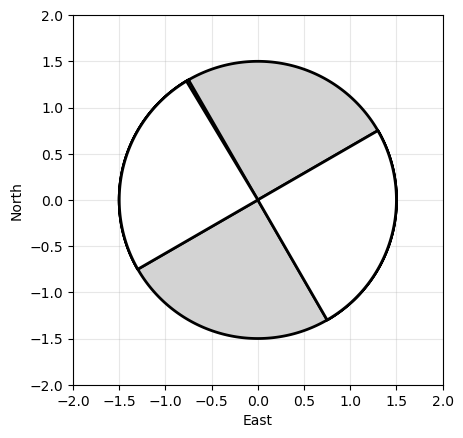

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach

def strike_dip_rake_to_mt(strike, dip, rake, M0=1.0):
    """
    Convert strike, dip, rake to moment tensor components for ObsPy beach function.
    
    Parameters
    ----------
    strike : float
        Strike angle in degrees (0-360), measured clockwise from north
    dip : float
        Dip angle in degrees (0-90), measured down from horizontal
    rake : float
        Rake angle in degrees (-180 to 180)
    M0 : float
        Scalar moment (default=1.0)
    
    Returns
    -------
    mt : list
        Moment tensor components [M11, M22, M33, M12, M13, M23] in ObsPy convention
    """
    # Convert angles to radians
    phi = np.deg2rad(strike)
    delta = np.deg2rad(dip)
    lambd = np.deg2rad(rake)
    
    # Calculate moment tensor components in Aki & Richards (NED) convention
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)
    sin_2phi = np.sin(2 * phi)
    cos_2phi = np.cos(2 * phi)
    sin_delta = np.sin(delta)
    cos_delta = np.cos(delta)
    sin_2delta = np.sin(2 * delta)
    cos_2delta = np.cos(2 * delta)
    sin_lambd = np.sin(lambd)
    cos_lambd = np.cos(lambd)
    
    # Aki & Richards (North-East-Down) convention
    Mxx = -M0 * (sin_delta * cos_lambd * sin_2phi + sin_2delta * sin_lambd * sin_phi**2)
    Myy = M0 * (sin_delta * cos_lambd * sin_2phi - sin_2delta * sin_lambd * cos_phi**2)
    Mzz = M0 * sin_2delta * sin_lambd
    Mxy = M0 * (sin_delta * cos_lambd * cos_2phi + 0.5 * sin_2delta * sin_lambd * sin_2phi)
    Mxz = -M0 * (cos_delta * cos_lambd * cos_phi + cos_2delta * sin_lambd * sin_phi)
    Myz = -M0 * (cos_delta * cos_lambd * sin_phi - cos_2delta * sin_lambd * cos_phi)
    
    # Convert to ObsPy (Up-South-East) convention
    M11 = Mzz  # Mrr
    M22 = Mxx  # Mtt
    M33 = Myy  # Mpp
    M12 = Mxz  # Mrt
    M13 = -Myz # Mrp
    M23 = -Mxy # Mtp
    
    return [M11, M22, M33, M12, M13, M23]


def rotate_moment_tensor(strike, dip, rake, v, theta, use_upper_hemisphere=False):
    """
    Rotate a moment tensor about an arbitrary axis.
    
    Parameters
    ----------
    strike : float
        Strike angle in degrees
    dip : float
        Dip angle in degrees
    rake : float
        Rake angle in degrees
    v : array-like
        Unit vector defining the rotation axis [vx, vy, vz]
        In geographic coordinates: x=North, y=East, z=Down
    theta : float
        Rotation angle in degrees (positive = counterclockwise when looking along v)
    use_upper_hemisphere : bool
        If True, convert to upper hemisphere before rotation (for map view to cross-section)
    
    Returns
    -------
    mt_rotated : list
        Rotated moment tensor components [M11, M22, M33, M12, M13, M23] for ObsPy
    
    Notes
    -----
    Uses Rodrigues' rotation formula to rotate the moment tensor.
    The rotation is performed in the North-East-Down coordinate system,
    then converted to ObsPy's Up-South-East convention.
    """
    # First, get the moment tensor from strike/dip/rake
    mt_obspy = strike_dip_rake_to_mt(strike, dip, rake)
    
    # If requested, convert to upper hemisphere before rotation
    if use_upper_hemisphere:
        mt_obspy = convert_to_upper_hemisphere(mt_obspy)
    
    # Convert from ObsPy (USE) to NED convention for rotation
    # ObsPy: 1=Up, 2=South, 3=East
    # NED: x=North, y=East, z=Down
    # Mrr=Mzz, Mtt=Mxx, Mpp=Myy, Mrt=Mxz, Mrp=-Myz, Mtp=-Mxy
    Mzz = mt_obspy[0]  # M11 = Mrr
    Mxx = mt_obspy[1]  # M22 = Mtt
    Myy = mt_obspy[2]  # M33 = Mpp
    Mxz = mt_obspy[3]  # M12 = Mrt
    Myz = -mt_obspy[4] # M13 = Mrp, so Myz = -Mrp
    Mxy = -mt_obspy[5] # M23 = Mtp, so Mxy = -Mtp
    
    # Build the moment tensor matrix in NED coordinates
    M_ned = np.array([[Mxx, Mxy, Mxz],
                      [Mxy, Myy, Myz],
                      [Mxz, Myz, Mzz]])
    
    # Normalize the rotation axis
    v = np.array(v, dtype=float)
    v = v / np.linalg.norm(v)
    
    # Special handling for cross-section view
    if use_upper_hemisphere and abs(v[2]) < 0.1:  # Horizontal rotation axis
        # Step 1: Calculate azimuth of the horizontal axis
        axis_azimuth = np.degrees(np.arctan2(v[1], v[0]))  # Azimuth from North
        
        # Step 2: Rotate about vertical (z-axis) by -axis_azimuth
        # This aligns the rotation axis with the E-W direction
        theta_vertical = np.radians(axis_azimuth)
        R_vertical = np.array([[np.cos(theta_vertical), -np.sin(theta_vertical), 0],
                               [np.sin(theta_vertical), np.cos(theta_vertical), 0],
                               [0, 0, 1]])
        
        # Apply vertical rotation
        M_ned = np.dot(np.dot(R_vertical, M_ned), R_vertical.T)
        
        # Step 3: Now rotate about E-W axis (y-axis in NED) by theta
        # Using right-hand rule: positive rotation tips northward side down
        theta_rad = np.deg2rad(theta)
        R_ew = np.array([[np.cos(theta_rad), 0, np.sin(theta_rad)],
                         [0, 1, 0],
                         [-np.sin(theta_rad), 0, np.cos(theta_rad)]])
        
        # Apply E-W rotation
        M_rotated_ned = np.dot(np.dot(R_ew, M_ned), R_ew.T)
        
    else:
        # Standard rotation using Rodrigues' formula for non-cross-section cases
        # Convert rotation angle to radians
        theta_rad = np.deg2rad(theta)
        
        # Build rotation matrix using Rodrigues' formula
        # R = I + sin(θ)K + (1-cos(θ))K²
        # where K is the skew-symmetric matrix of v
        I = np.eye(3)
        K = np.array([[0, -v[2], v[1]],
                      [v[2], 0, -v[0]],
                      [-v[1], v[0], 0]])
        
        cos_theta = np.cos(theta_rad)
        sin_theta = np.sin(theta_rad)
        
        R = I + sin_theta * K + (1 - cos_theta) * np.dot(K, K)
        
        # Rotate the moment tensor: M' = R * M * R^T
        M_rotated_ned = np.dot(np.dot(R, M_ned), R.T)
    
    # Extract components
    Mxx_rot = M_rotated_ned[0, 0]
    Myy_rot = M_rotated_ned[1, 1]
    Mzz_rot = M_rotated_ned[2, 2]
    Mxy_rot = M_rotated_ned[0, 1]
    Mxz_rot = M_rotated_ned[0, 2]
    Myz_rot = M_rotated_ned[1, 2]
    
    # Convert back to ObsPy (USE) convention
    M11_rot = Mzz_rot  # Mrr
    M22_rot = Mxx_rot  # Mtt
    M33_rot = Myy_rot  # Mpp
    M12_rot = Mxz_rot  # Mrt
    M13_rot = -Myz_rot # Mrp
    M23_rot = -Mxy_rot # Mtp
    
    return [M11_rot, M22_rot, M33_rot, M12_rot, M13_rot, M23_rot]


def convert_to_upper_hemisphere(mt_obspy):
    """
    Convert moment tensor to upper hemisphere projection.
    
    This flips the sign of components that involve the vertical (Up) direction
    to simulate viewing the beach ball from above instead of below.
    
    Parameters
    ----------
    mt_obspy : list
        Moment tensor components [M11, M22, M33, M12, M13, M23] in ObsPy convention
        where 1=Up, 2=South, 3=East
    
    Returns
    -------
    mt_upper : list
        Moment tensor components for upper hemisphere projection
    """
    # In ObsPy convention: 1=Up, 2=South, 3=East
    # For upper hemisphere, we flip components involving the Up (1) direction
    M11 = mt_obspy[0]  # Mrr (Up-Up) - no change
    M22 = mt_obspy[1]  # Mtt (South-South) - no change
    M33 = mt_obspy[2]  # Mpp (East-East) - no change
    M12 = -mt_obspy[3] # Mrt (Up-South) - flip sign
    M13 = -mt_obspy[4] # Mrp (Up-East) - flip sign
    M23 = mt_obspy[5]  # Mtp (South-East) - no change
    
    return [M11, M22, M33, M12, M13, M23]


def vector_from_trend_plunge(trend, plunge=0):
    """
    Convert trend and plunge to a unit vector in NED coordinates.
    
    Parameters
    ----------
    trend : float
        Azimuth in degrees, measured clockwise from North (0-360)
    plunge : float
        Plunge in degrees, positive downward (0-90)
    
    Returns
    -------
    v : array
        Unit vector [North, East, Down]
    """
    trend_rad = np.deg2rad(trend)
    plunge_rad = np.deg2rad(plunge)
    
    # In NED coordinates
    v_north = np.cos(trend_rad) * np.cos(plunge_rad)
    v_east = np.sin(trend_rad) * np.cos(plunge_rad)
    v_down = np.sin(plunge_rad)
    
    return np.array([v_north, v_east, v_down])


strike = 315
dip = 60
rake = 90

v = np.array([1, 1, 0])
theta = 90  # rotation angle in degrees - gets into cross-sectional view.
    
mt_rotated = rotate_moment_tensor(strike, dip, rake, v, theta, use_upper_hemisphere=True)

fig = plt.figure()
ax = plt.gca()
ball1 = beach(mt_rotated, xy=(0, 0), width=3,
              facecolor='lightgray', edgecolor='black', linewidth=2)
ax.add_collection(ball1)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.set_xlabel('East')
ax.set_ylabel('North')
ax.grid(True, alpha=0.3)
        
plt.show()
    